In [85]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from tqdm.notebook import tqdm

from util.data import load_mnist, encode_data, add_noise
from util.plots import plot_images, plot_image
from util.metrics import (
    get_sp_stability,
    calc_noise_robustness,
    calculate_overlap,
    calculate_entropy,
)

from algorithms import SpatialPooler

<IPython.core.display.Javascript object>

In [87]:
experiment_path = "data/12-04-2022_15-51-52"
trained_sp_path = f"{experiment_path}/sp_epoch_20.pkl"

<IPython.core.display.Javascript object>

In [88]:
(_, _), (x_test, y_test) = load_mnist()
x_test = encode_data(x_test)

<IPython.core.display.Javascript object>

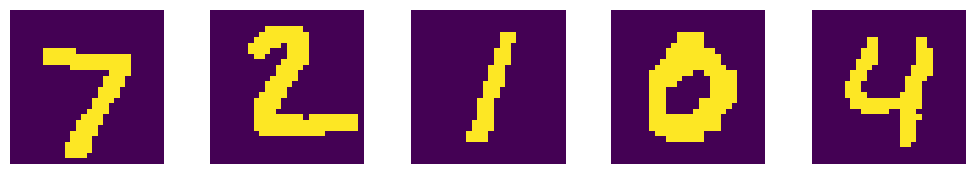

<IPython.core.display.Javascript object>

In [89]:
plot_images(x_test[:5])

In [90]:
sp = SpatialPooler(
    input_dimension=x_test[0].shape,
    column_dimension=(45, 45),
    connection_sparsity=0.7,
    permanence_threshold=0.5,
    stimulus_threshold=10,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=0.02,
    potential_pool_radius=8,
    boost_strength=10,
)
sp.load_state(trained_sp_path)

<IPython.core.display.Javascript object>

<AxesSubplot:>

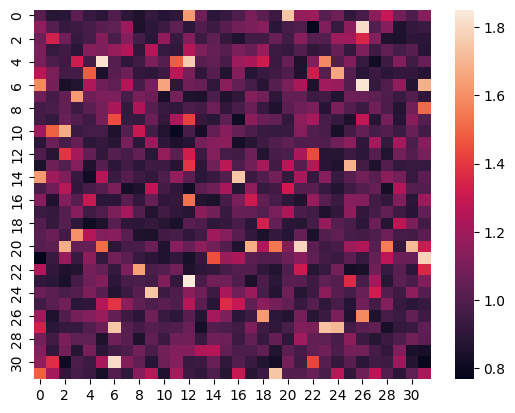

<IPython.core.display.Javascript object>

In [91]:
sns.heatmap(sp.boost_factors.reshape(32, 32))

<AxesSubplot:>

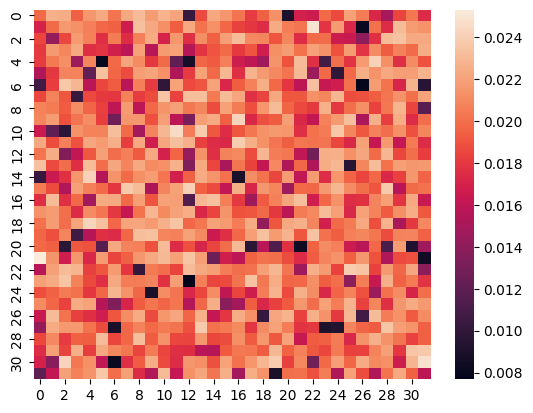

<IPython.core.display.Javascript object>

In [92]:
sns.heatmap(sp.active_duty_cycle.reshape((32, 32)))

<AxesSubplot:>

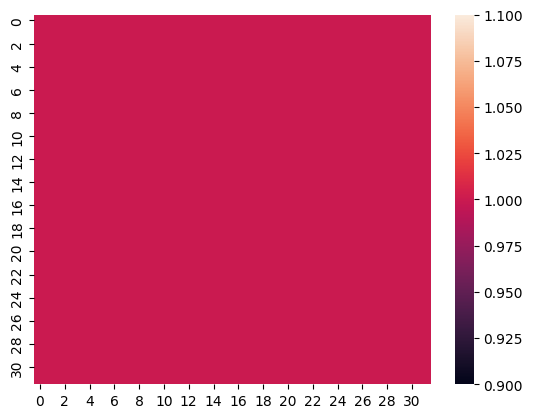

<IPython.core.display.Javascript object>

In [93]:
sns.heatmap(sp.overlap_duty_cycles.reshape((32, 32)))

In [94]:
sp.permanences[500:510].shape

(10, 784)

<IPython.core.display.Javascript object>

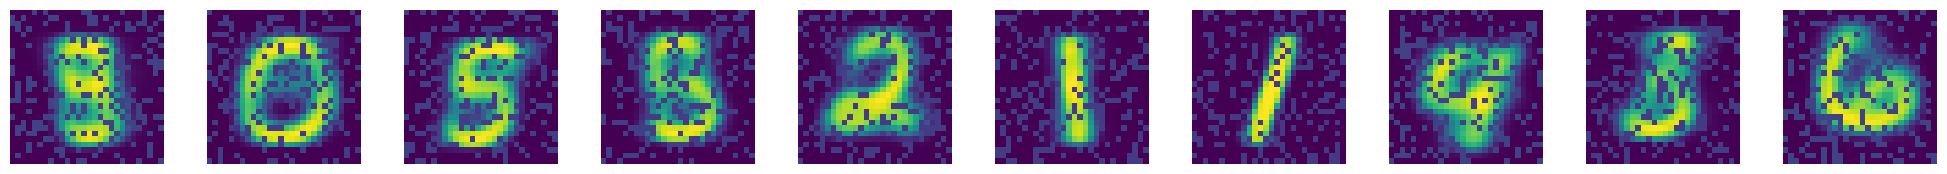

<IPython.core.display.Javascript object>

In [95]:
plot_images(sp.permanences[600:610].reshape((10, 28, 28)))

In [96]:
results = pd.read_csv(f"{experiment_path}/results.csv", index_col=0)
results

,entropy,activation_freq,sparsity,stability,noise_robustness
0,0.095759,[0.0151 0.0042 0.0023 ... 0.0106 0.0176 0.0005],0.019531,[[0.396 0.0555 0.18 0.162 0.1515 0.136 0....,0.042268
1,0.117524,[0.0241 0.0186 0.0087 ... 0.0089 0.0383 0.0279],0.019531,[[0.362 0.02 0.0645 0.073 0.0605 0.0815 0....,0.046932
2,0.117618,[0.0242 0.0182 0.0087 ... 0.009 0.0356 0.0276],0.019531,[[0.347 0.016 0.0625 0.0665 0.0545 0.086 0....,0.046720
3,0.117703,[0.0235 0.0177 0.008 ... 0.0085 0.0364 0.0267],0.019531,[[0.363 0.0145 0.061 0.068 0.0585 0.0875 0....,0.045757
4,0.117800,[0.0235 0.0178 0.0084 ... 0.0086 0.0353 0.0267],0.019531,[[0.353 0.015 0.0585 0.0695 0.0505 0.0935 0....,0.045087
5,0.117872,[0.0241 0.0174 0.0079 ... 0.0089 0.0356 0.0265],0.019531,[[0.347 0.013 0.0545 0.064 0.047 0.083 0....,0.046212
6,0.117942,[0.0241 0.0173 0.0077 ... 0.0088 0.0338 0.0268],0.019531,[[0.34 0.013 0.0605 0.065 0.0495 0.0855 0....,0.045120
7,0.117935,[0.0238 0.0178 0.0087 ... 0.0087 0.0339 0.0266],0.019531,[[0.338 0.014 0.058 0.0685 0.0515 0.089 0....,0.045484
8,0.117968,[0.0238 0.0184 0.0085 ... 0.0089 0.0335 0.0267],0.019531,[[0.35 0.014 0.058 0.066 0.053 0.081 0....,0.046035
9,0.117981,[0.0237 0.0179 0.0087 ... 0.0087 0.0336 0.0264],0.019531,[[0.342 0.0135 0.054 0.0615 0.047 0.0805 0....,0.045915


<IPython.core.display.Javascript object>

<AxesSubplot:>

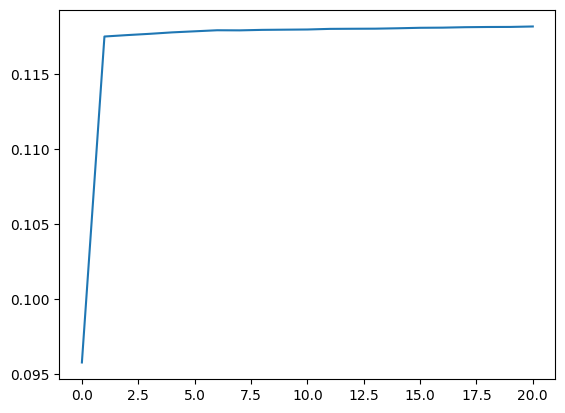

<IPython.core.display.Javascript object>

In [97]:
results.entropy.plot()

In [116]:
ast.literal_eval(results.activation_freq.iloc[0].replace(" ", ","))

[0.0151, 0.0042, 0.0023, Ellipsis, 0.0106, 0.0176, 0.0005]

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Probability'>

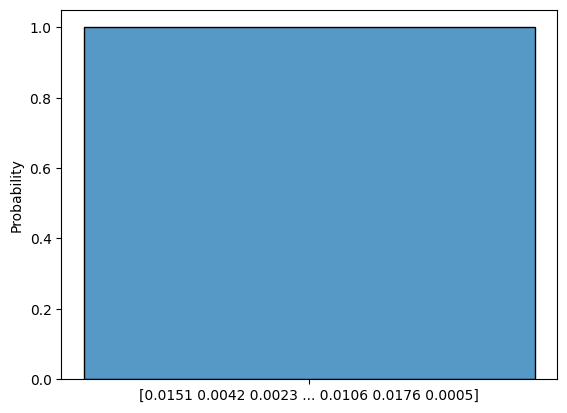

<IPython.core.display.Javascript object>

In [102]:
sns.histplot(results.activation_freq.iloc[0], stat="probability", bins=10)

<AxesSubplot:>

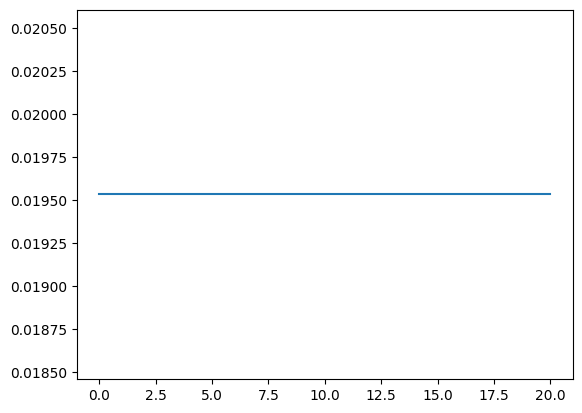

<IPython.core.display.Javascript object>

In [98]:
results.sparsity.plot()

<AxesSubplot:>

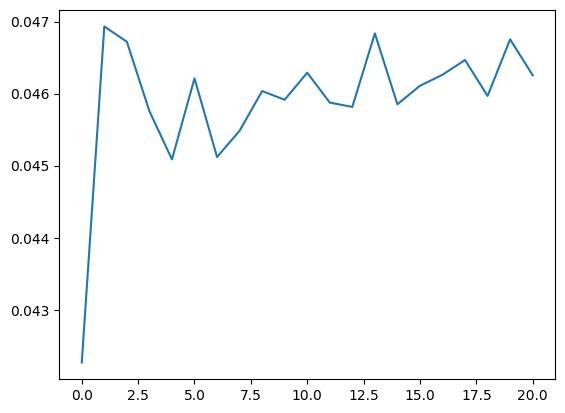

<IPython.core.display.Javascript object>

In [99]:
results.noise_robustness.plot()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 126.06it/s]


<AxesSubplot:>

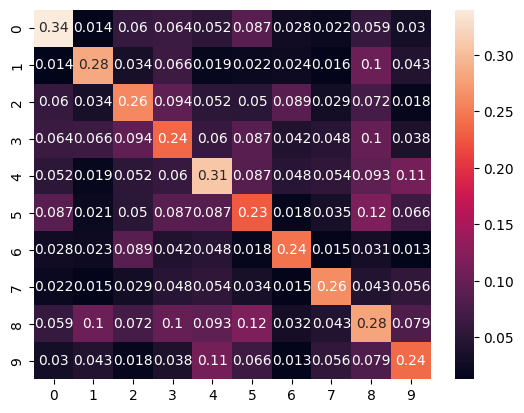

<IPython.core.display.Javascript object>

In [82]:
stability = get_sp_stability(sp, x_test.reshape((10000, 784)), y_test)
sns.heatmap(stability, annot=True)

In [39]:
noise_test = x_test[1].flatten()

no_steps = 100

noise_lvs = [n / no_steps for n in range(0, no_steps)]

wc = sp.compute(noise_test, learn=False)
sdr = sp.top_columns_to_sdr(wc)

no_on_bits_sdr = len(wc)

shared_bits_fracs = []

noisy_images = []

for k in tqdm(noise_lvs):
    noisy_img = add_noise(noise_test, k)
    noisy_images.append(noisy_img)

    noisy_wc = sp.compute(noisy_img, learn=False)
    noisy_sdr = sp.top_columns_to_sdr(noisy_wc)

    overlap = calculate_overlap(sdr, noisy_sdr)

    shared_bits_frac = overlap / no_on_bits_sdr

    shared_bits_fracs.append(shared_bits_frac)
    
noisy_images = [i.reshape((28, 28)) for i in noisy_images]

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

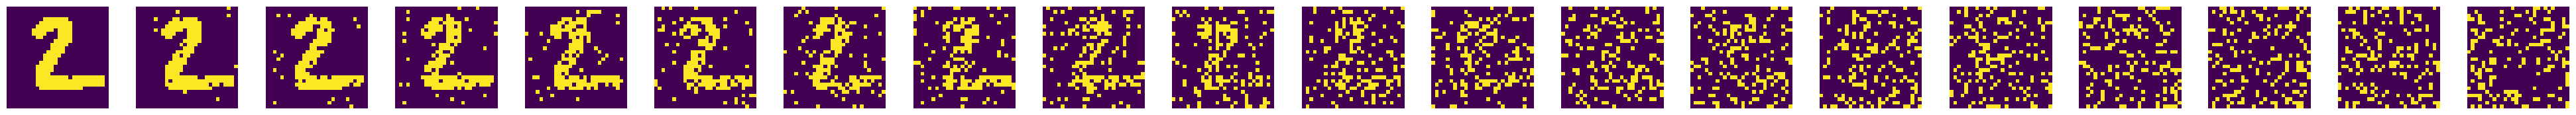

<IPython.core.display.Javascript object>

In [44]:
plot_images(np.array(noisy_images[::5]))

<AxesSubplot:>

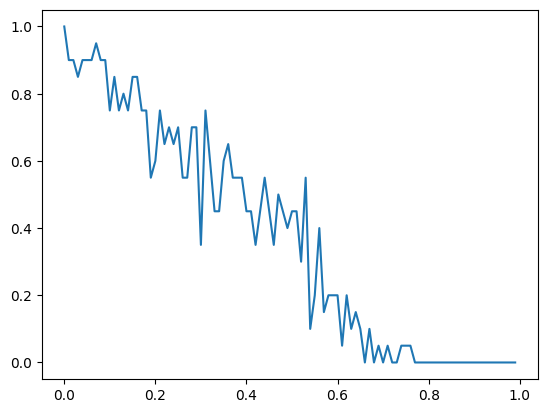

<IPython.core.display.Javascript object>

In [45]:
sns.lineplot(y=shared_bits_fracs, x=noise_lvs)

In [47]:
from scipy.signal import savgol_filter
from scipy.integrate import quad

<IPython.core.display.Javascript object>

<AxesSubplot:>

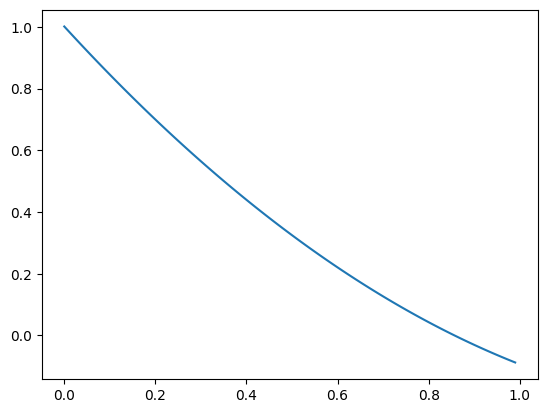

<IPython.core.display.Javascript object>

In [48]:
filter_val = savgol_filter(shared_bits_fracs, 100, 2)
sns.lineplot(y=filter_val, x=[i / 100 for i in range(0, 100)])

In [51]:
np.sum(filter_val / no_steps)

0.37349999999999955

<IPython.core.display.Javascript object>

In [77]:
calc_noise_robustness(sp, x_test.reshape((10000, 784))[:5])

5it [00:45,  9.00s/it]


0.047156686334761125

<IPython.core.display.Javascript object>

In [52]:
entropy, activation_freq = calculate_entropy(sp, x_test.reshape((10000, 784)))
entropy

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 228.31it/s]


0.11263589252389006

<IPython.core.display.Javascript object>

In [54]:
activation_freq

array([0.0263, 0.    , 0.0077, ..., 0.0102, 0.0297, 0.0405])

<IPython.core.display.Javascript object>

In [57]:
from matplotlib.ticker import PercentFormatter

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Probability'>

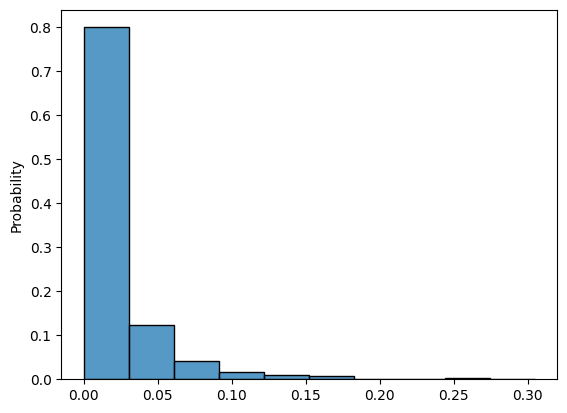

<IPython.core.display.Javascript object>

In [70]:
sns.histplot(activation_freq, stat="probability", bins=10)

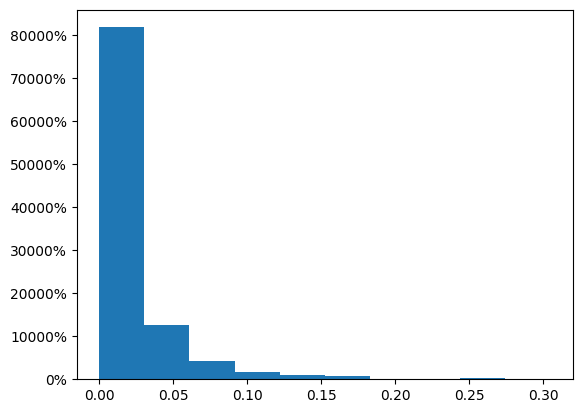

<IPython.core.display.Javascript object>

In [60]:
plt.hist(activation_freq)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()